# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage and amino acid mutation features.

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_median
from pyro.optim import Adam, ClippedAdam
from pyrocov import pangolin

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
nextclade --input-fasta results/gisaid.subset.fasta \
          --output-tsv results/gisaid.subset.tsv
python featurize_nextclade.py
```

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 715318 rows with columns:
accession_id, collection_date, location, add_location, lineage, day


In [3]:
lineages = list(map(pangolin.compress, columns["lineage"]))
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 880 lineages
------------------------------
    144992 B.1.1.7
     92250 B.1.177
     60184 B.1
     51615 B.1.2
     21414 B.1.1.29
     18772 B.1.160
     12353 D.2
      9401 B.1.177.21
      8409 C
      8196 B.1.258
      8103 B.1.221
      7617 B.1.1.284


In [4]:
locations = columns["location"]
print(f"Top 12 of {len(set(locations))} lineages")
print("-" * 30)
for location, count in Counter(locations).most_common(12):
    print(f"{count: >10d} {location}")

Top 12 of 7015 lineages
------------------------------
    225318 Europe / United Kingdom / England
     29619 Europe / United Kingdom / Wales
     21564 Europe / Denmark / Hovedstaden
     20522 Asia / Japan
     19403 Europe / United Kingdom / Scotland
     18549 North America / USA / Texas / Houston
     13654 Oceania / Australia / Victoria
      8462 Europe / Denmark / Syddanmark
      8018 North America / USA / California
      7797 North America / USA / Michigan
      7534 Europe / Denmark / Midtjylland
      6713 Europe / Denmark / Sjaelland


In [5]:
aa_features = torch.load("results/nextclade.features.pt")
print(aa_features.keys())

dict_keys(['lineages', 'mutations', 'features'])


In [6]:
print(aa_features["features"].shape)

torch.Size([880, 10011])


## Aggregating regions and lineages

We'll aggregate locations by either US state, UK regions, or other country.

In [7]:
features = aa_features["features"]
lineages = list(map(pangolin.compress, columns["lineage"]))
lineage_id_inv = list(map(pangolin.compress, aa_features["lineages"]))
lineage_id = {k: i for i, k in enumerate(lineage_id_inv)}

In [8]:
sparse_data = Counter()
location_id = {}
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] not in ("USA", "United Kingdom"):
        parts = parts[:2]
    location = " / ".join(parts)
    p = location_id.setdefault(location, len(location_id))
    s = lineage_id[lineage]
    t = day // 7
    sparse_data[t, p, s] += 1
    
T = 1 + max(columns["day"]) // 7
P = len(location_id)
S = len(lineage_id)
dense_data = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    dense_data[t, p, s] = n
print(dense_data.shape, dense_data.shape.numel())

torch.Size([66, 229, 880]) 13300320


## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This ignores any spatial structure across regions.

In [9]:
def model(dense_data, features, feature_scale=1.0):
    assert dense_data.shape[-1] == features.shape[0]
    T, P, S = dense_data.shape
    S, F = features.shape
    time_plate = pyro.plate("time", T, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * 7 / 365.25  # in years
    time -= time.max()
    
    # Assume relative growth rate depends on kmer features but not time or place.
    log_rate_coef = pyro.sample(
        "log_rate_coef", dist.Laplace(0, feature_scale).expand([F]).to_event(1)
    )
    log_rate = pyro.deterministic("log_rate", log_rate_coef @ features.T)

    # Assume places differ only in their initial infection count.
    with place_plate:
        log_init = pyro.sample(
            "log_init", dist.Normal(0, 10).expand([S]).to_event(1)
        )

    # Finally observe overdispersed counts.
    concentration = pyro.sample("concentration", dist.LogNormal(2, 4))
    base_rate = (log_init + log_rate * time[:, None, None]).softmax(dim=-1)
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=dense_data.sum(-1).max(),
                concentration=concentration * base_rate,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=dense_data,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [10]:
def init_loc_fn(site):
    if site["name"] in ("log_init", "log_rate_coef"):
        return torch.zeros(site["fn"].shape())
    return init_to_median(site)

Traning guide with 211532 parameters:
step    0 loss = 19.5	conc. = 1.08
step   20 loss = 17.3	conc. = 2.92
step   40 loss = 16.6	conc. = 7.95
step   60 loss = 16.3	conc. = 9.71
step   80 loss = 16.1	conc. = 11.6
step  100 loss = 15.9	conc. = 14.4
step  120 loss = 15.8	conc. = 18.2
step  140 loss = 15.8	conc. = 21.8
step  160 loss = 15.7	conc. = 24.5
step  180 loss = 15.7	conc. = 25.8
step  200 loss = 15.7	conc. = 27.7
step  220 loss = 15.7	conc. = 28.9
step  240 loss = 15.6	conc. = 29.3
step  260 loss = 15.6	conc. = 29.9
step  280 loss = 15.6	conc. = 30
step  300 loss = 15.6	conc. = 30.6
CPU times: user 2min 46s, sys: 1min 8s, total: 3min 55s
Wall time: 1min 30s


Text(0, 0.5, 'loss')

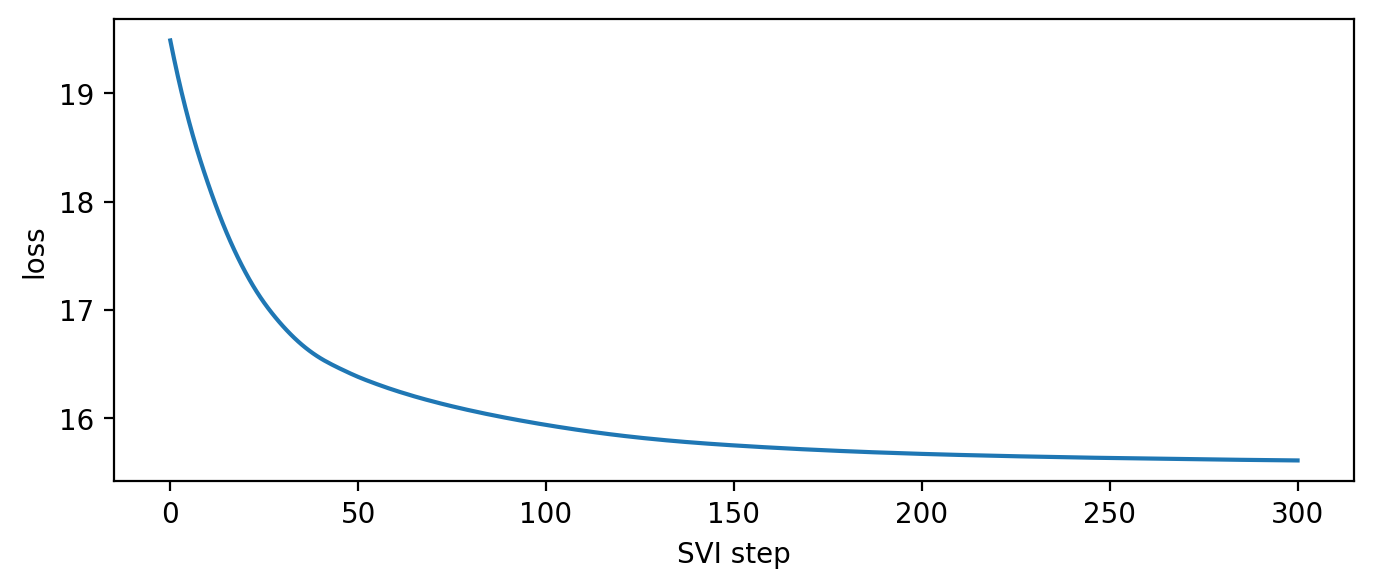

In [11]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210223)

guide = AutoDelta(model, init_loc_fn=init_loc_fn)
guide(dense_data, features)  # Initializes guide so we can count parameters.
print("Traning guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = ClippedAdam({"lr": 0.05})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = dense_data.count_nonzero()
for step in range(301):
    loss = svi.step(dense_data, features) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 20 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}")
        
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [12]:
with torch.no_grad():
    median = {k: v.detach() for k, v in guide.median().items()}
median["log_rate"] = median["log_rate_coef"] @ features.T
print(", ".join(median.keys()))

log_rate_coef, log_init, concentration, log_rate


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative transmissibility looks suspciously diverse, suggesting we should probably add process noise to our model.

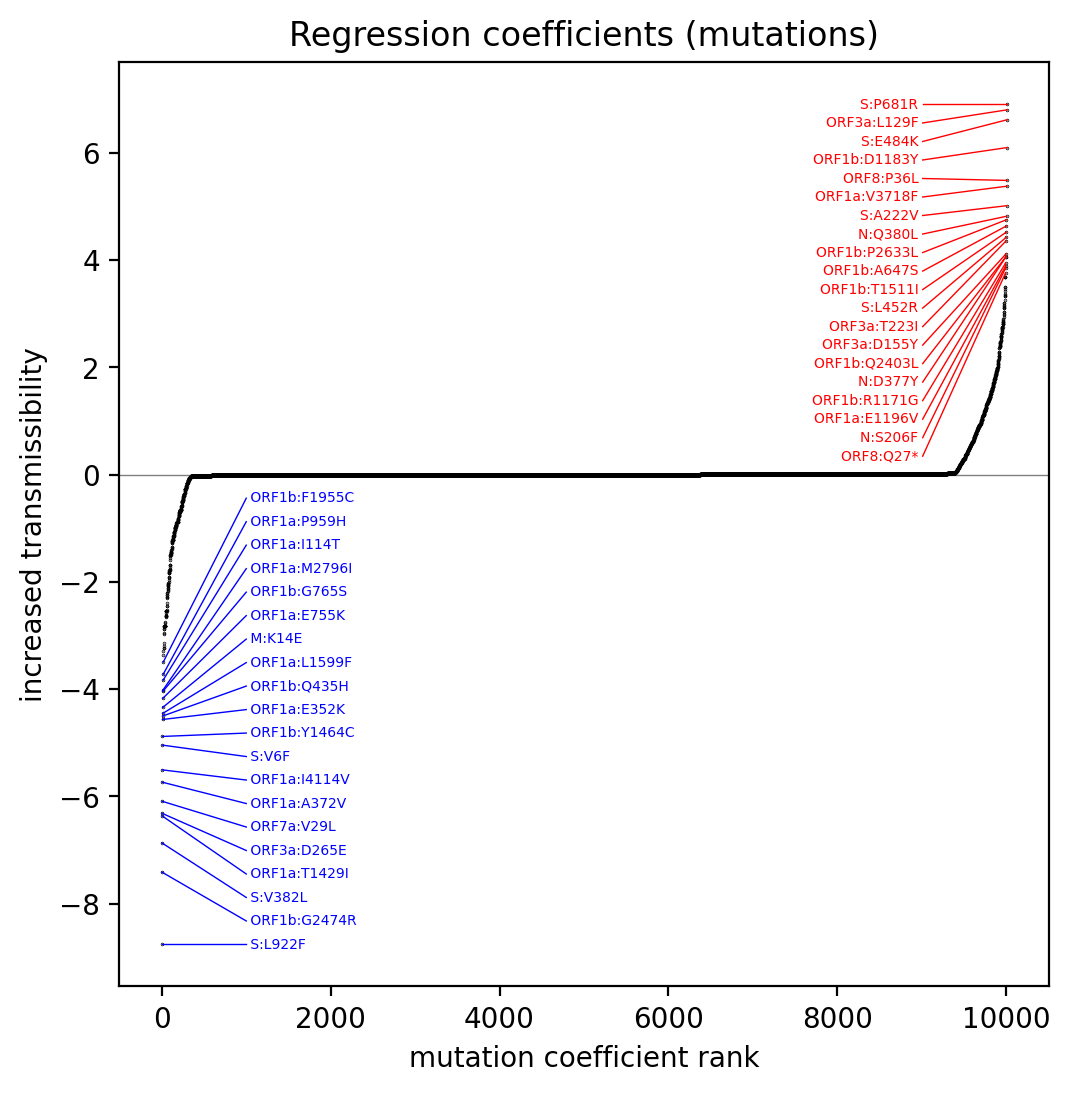

In [13]:
mutations = aa_features['mutations']
xs, idx = median["log_rate_coef"].sort(0)
assert len(idx) == len(mutations)
plt.figure(figsize=(6, 6))
plt.title("Regression coefficients (mutations)")
plt.plot(xs, 'k.', lw=0, markersize=0.5)
plt.axhline(0, color='black', lw=0.5, alpha=0.5)
plt.xlabel("mutation coefficient rank")
plt.ylabel("increased transmissibility")

I = len(idx)
for i in range(20):
    x = I / 10
    y = xs.min() * (1 - i / 20)
    plt.plot([i, x], [xs[i], y], color='blue', lw=0.5)
    plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='blue',
             verticalalignment="center", horizontalalignment="left")
for i in range(I - 20, I):
    x = I - I / 10
    y = xs.max() * (1 - (I - i - 1) / 20)
    plt.plot([i, x], [xs[i], y], color='red', lw=0.5)
    plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='red',
             verticalalignment="center", horizontalalignment="right")

We can also examine coefficients of some known mutations.

In [14]:
for name in ["N501Y", "D614G"]:
    i, = [i for i, m in enumerate(mutations) if name in m]
    coef = float(median["log_rate_coef"][i])
    print(f"{name} increases transmissibility by {coef:0.3g}")

N501Y increases transmissibility by 2.2
D614G increases transmissibility by 1.51


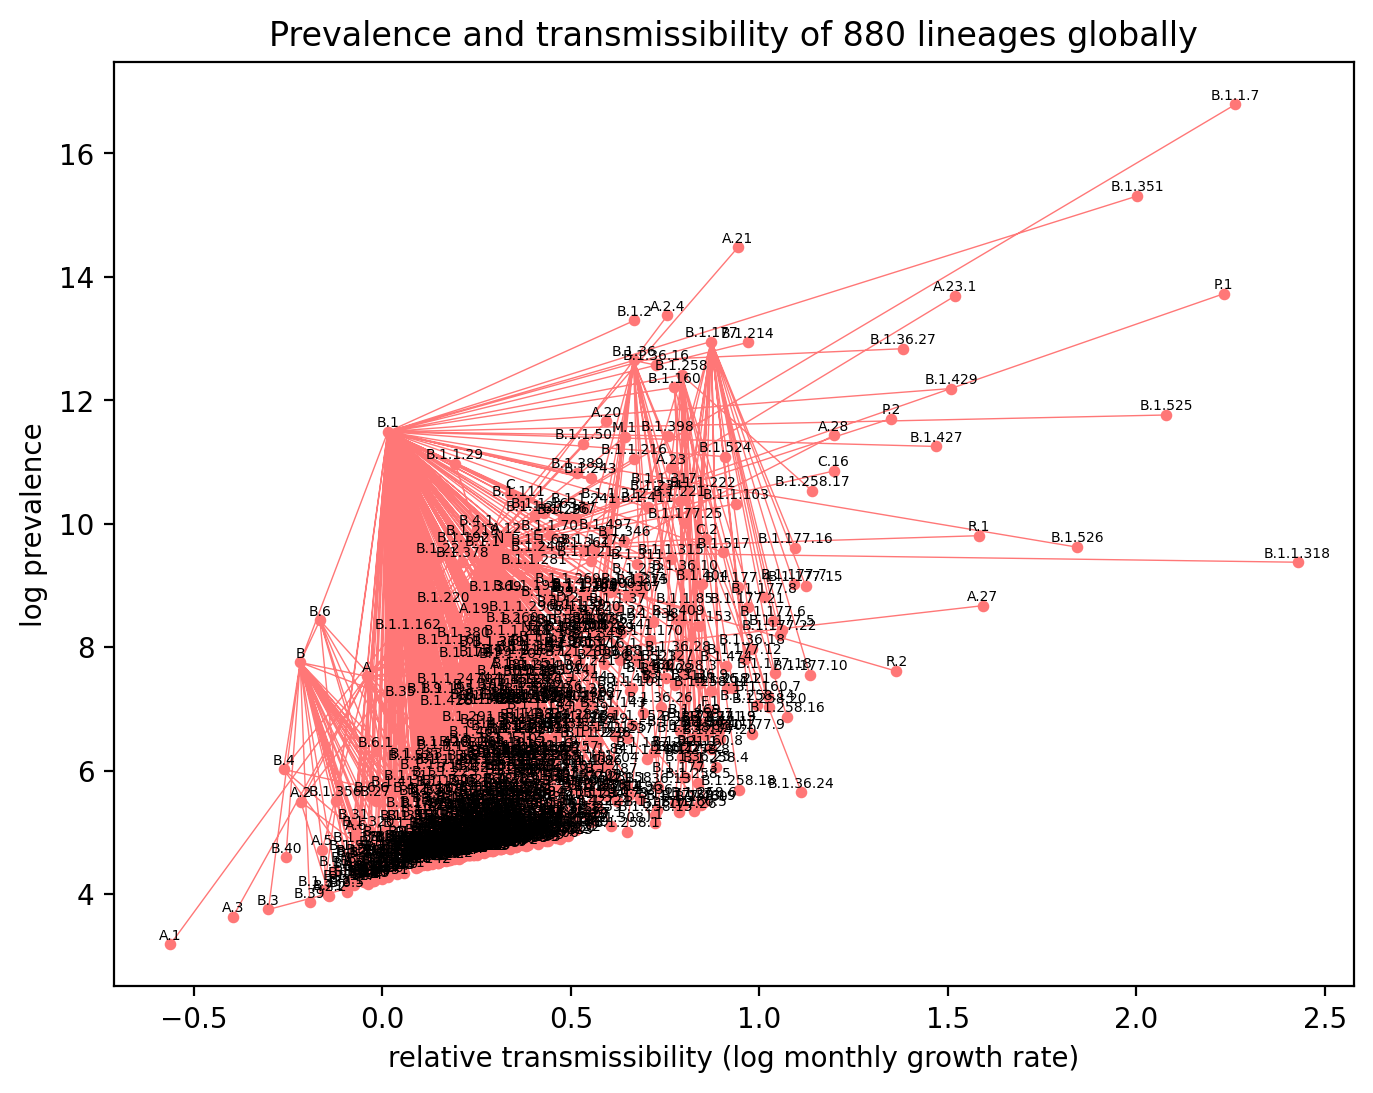

In [15]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = dense_data.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = median["log_rate"] / 12
    log_init = median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(max_len=7)

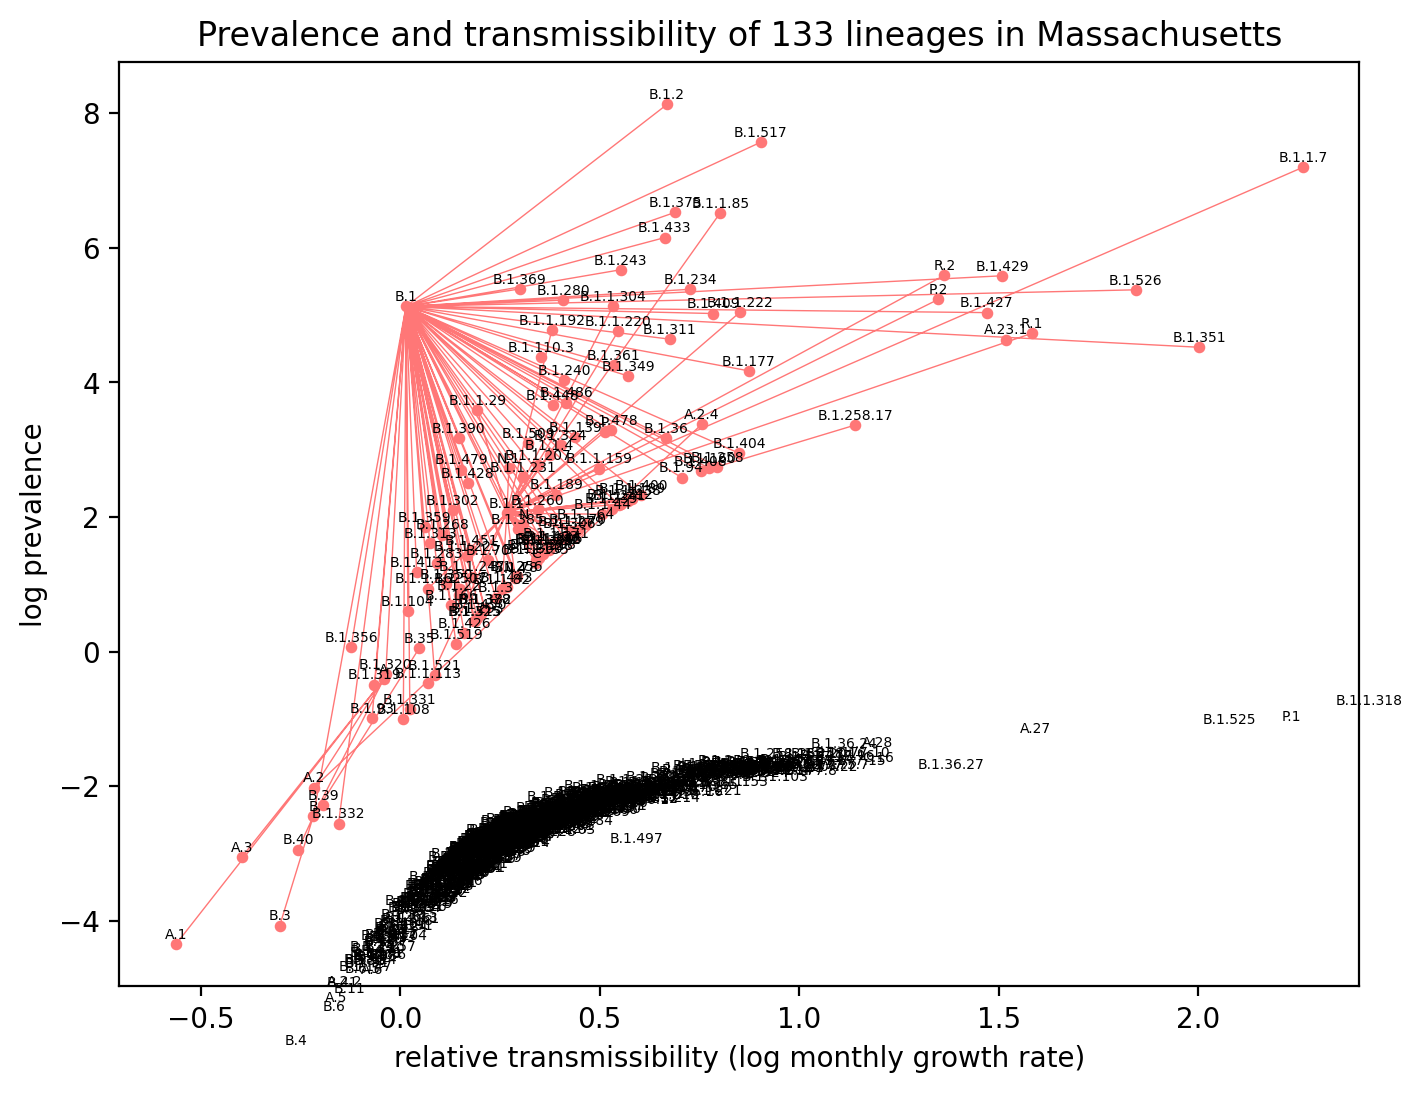

In [16]:
plot_prevalence("Massachusetts")

Finally we can use our logistic curves to forecast lineage prevalence in each region:

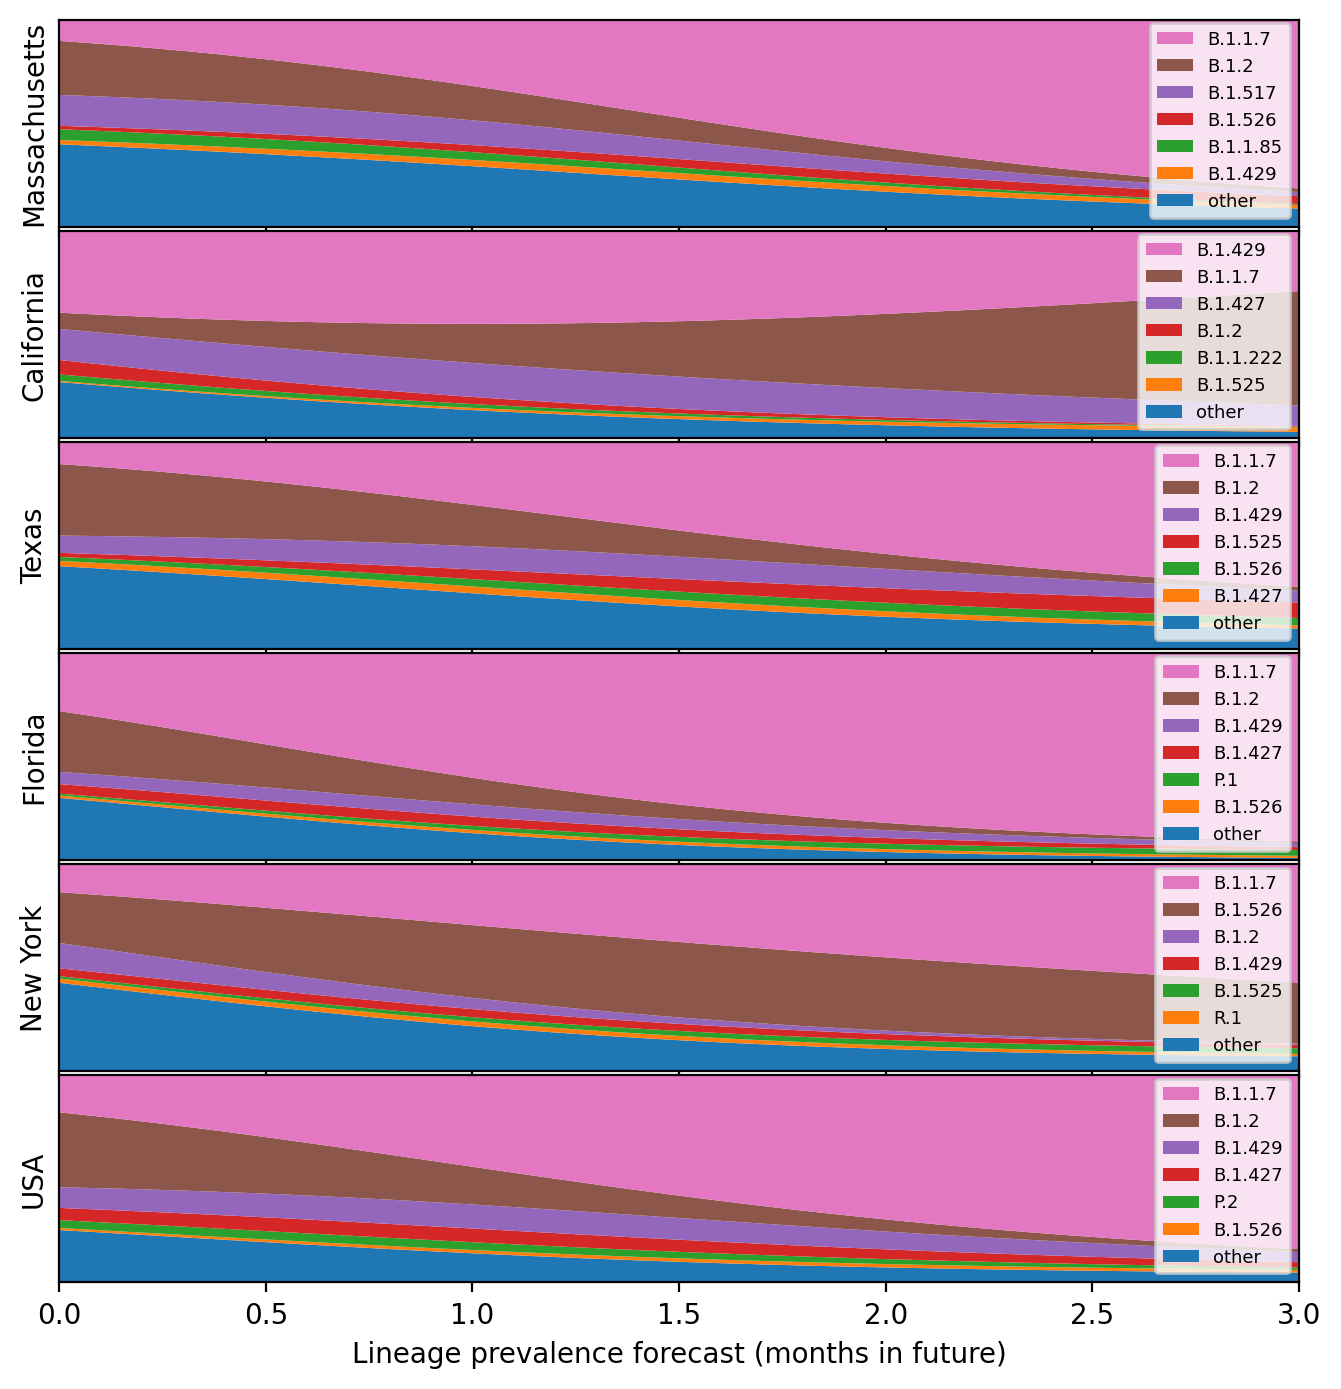

In [17]:
def plot_decomposition(queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])